# Bitcoin Time Series Forecasting  - Part 4: Random Forest Classification

# Introduction

In the fourth part of the project I continue to formulate Bitcoin price forecasting as a binary classification problem. This time, however, I train Random Forest classifier on a sequence of past data points to predict a price increase or decrease in the next time step. Once again I do this on both the raw time series and the time series of returns. 

Loading several needed packages:

In [2668]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
#%matplotlib # to prevent duplicate plots by statsmodels 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

<Figure size 432x288 with 0 Axes>

Loading various modules related to Random Forest classification.

In [2669]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean, std

### Data Loading and Preparation

The data loading and following few steps are repeats of the previous part.

In [2670]:
data = pd.read_csv('c:\\users\jamil\AnacondaProjects\Mariani_Prado\Kraken_BTCUSD_1h.csv', index_col= 0)
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01-AM,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 12-AM,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 11-PM,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 10-PM,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 09-PM,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51


In [2671]:
data.index = pd.to_datetime(data.index, format='%Y-%m-%d %I-%p')
data.head(10)

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2019-06-28 01:00:00,BTCUSD,11468.6,11533.0,11200.9,11478.4,365.78,4184793.31
2019-06-28 00:00:00,BTCUSD,11148.0,11468.6,11002.6,11468.6,814.75,9215735.83
2019-06-27 23:00:00,BTCUSD,11089.4,11335.0,10905.9,11148.0,971.72,10836698.04
2019-06-27 22:00:00,BTCUSD,10729.0,11144.0,10665.6,11089.4,896.88,9785079.35
2019-06-27 21:00:00,BTCUSD,10678.8,10837.1,10456.4,10729.0,672.38,7177959.51
2019-06-27 20:00:00,BTCUSD,10830.9,10899.8,10300.0,10678.8,1489.22,15715577.13
2019-06-27 19:00:00,BTCUSD,10995.4,10995.4,10520.4,10830.9,1191.77,12846614.99
2019-06-27 18:00:00,BTCUSD,10805.5,11097.5,10638.6,10995.4,971.41,10603374.74
2019-06-27 17:00:00,BTCUSD,10887.6,10920.0,10355.2,10805.5,2331.37,24900968.86


In [2672]:
data=data.reindex(index=data.index[::-1])
data.head()

,Symbol,Open,High,Low,Close,Volume BTC,Volume USD
Date,,,,,,,
2017-07-01 11:00:00,BTCUSD,2491.97,2494.93,2483.32,2494.87,163.92,407837.90
2017-07-01 12:00:00,BTCUSD,2494.87,2494.87,2470.86,2477.97,80.93,200771.78
2017-07-01 13:00:00,BTCUSD,2477.97,2478.96,2444.44,2444.44,168.69,415839.42
2017-07-01 14:00:00,BTCUSD,2444.44,2463.60,2437.26,2448.99,119.59,292801.90
2017-07-01 15:00:00,BTCUSD,2448.99,2465.95,2438.99,2457.84,109.53,268333.15


Extracting the time series closing Bitcoin prices.

In [2673]:
rawdata = (data['Close'])

In [2674]:
rawdata.head()

Date
2017-07-01 11:00:00    2494.87
2017-07-01 12:00:00    2477.97
2017-07-01 13:00:00    2444.44
2017-07-01 14:00:00    2448.99
2017-07-01 15:00:00    2457.84
Name: Close, dtype: float64

### Bitcoin Price Time Series

<AxesSubplot:xlabel='Date'>

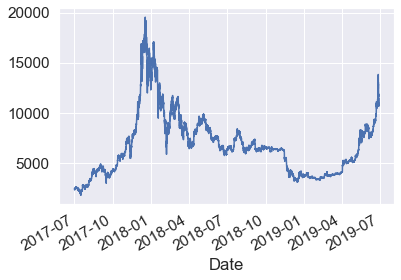

In [2675]:
rawdata.plot()

<AxesSubplot:ylabel='Frequency'>

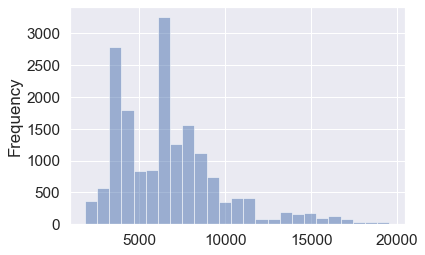

In [2676]:
rawdata.plot.hist(bins=25, alpha=0.5)

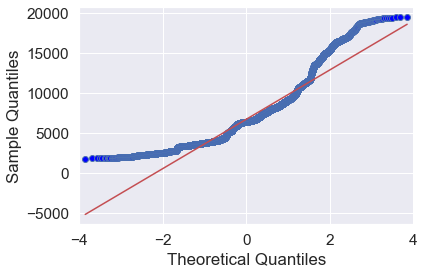

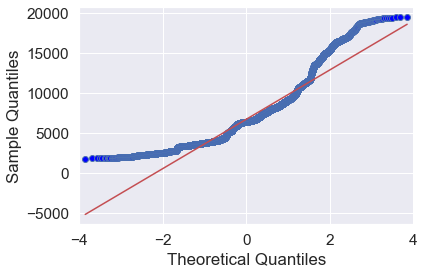

In [2677]:
qqplot(rawdata, line='s')

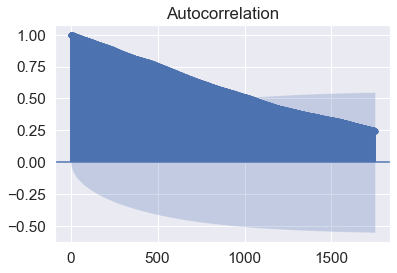

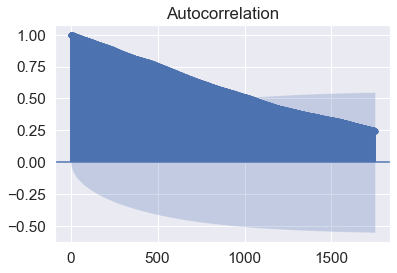

In [2678]:
sm.graphics.tsa.plot_acf(rawdata, lags=1750)

### The Time Series of First Differences or Returns

<AxesSubplot:xlabel='Date'>

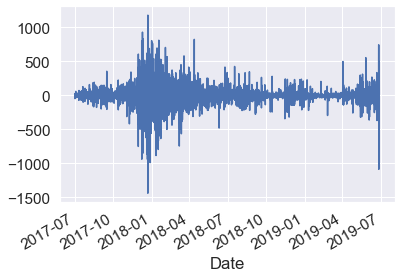

In [2679]:
shiftdata = rawdata.shift(1)
diff = rawdata - shiftdata
diff.dropna()
diff.plot()

In [2680]:
len(diff)

17439

In [2681]:
diff.head()

Date
2017-07-01 11:00:00      NaN
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
Name: Close, dtype: float64

In [2682]:
diff = diff.dropna()

In [2683]:
diff.head()

Date
2017-07-01 12:00:00   -16.90
2017-07-01 13:00:00   -33.53
2017-07-01 14:00:00     4.55
2017-07-01 15:00:00     8.85
2017-07-01 16:00:00    -1.39
Name: Close, dtype: float64

<AxesSubplot:ylabel='Frequency'>

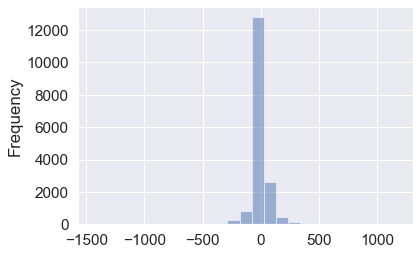

In [2684]:
diff.plot.hist(bins=25, alpha=0.5)

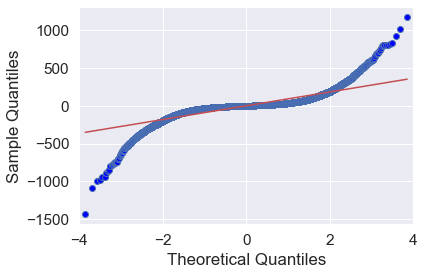

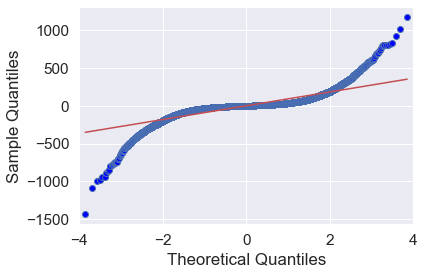

In [2685]:
qqplot(diff, line='s')

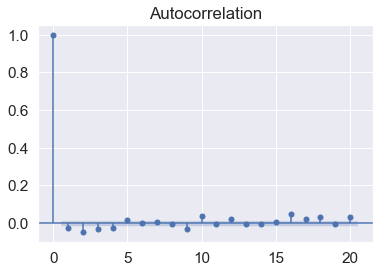

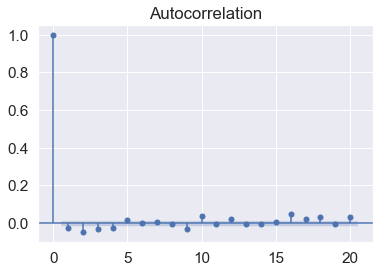

In [2686]:
sm.graphics.tsa.plot_acf(diff, lags=20)

##  Random Forest Forecasting 

### Data Preparation for Binary Classification - Raw Time Series

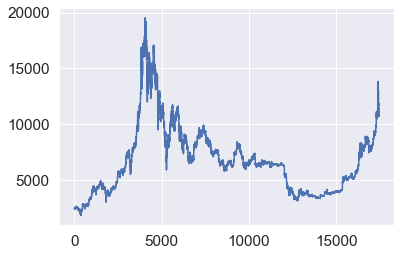

In [2687]:
data = rawdata.values
plt.plot(data)

In [2688]:
WINDOW = 30
STEP = 1
FORECAST = 1

In [2689]:
# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1]
        else:
            y_i = [0] 

    except Exception as e:
        print ("e")
        break

    X.append(x_i)
    Y.append(y_i)

e


In [2690]:
import numpy.ma as ma

In [2691]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)
print(X.shape)
X


(17408, 30)


array([[ 2494.87,  2477.97,  2444.44, ...,  2406.26,  2433.  ,  2448.  ],
       [ 2477.97,  2444.44,  2448.99, ...,  2433.  ,  2448.  ,  2470.01],
       [ 2444.44,  2448.99,  2457.84, ...,  2448.  ,  2470.01,  2475.  ],
       ...,
       [13580.  , 13456.4 , 13800.  , ..., 10830.9 , 10678.8 , 10729.  ],
       [13456.4 , 13800.  , 13839.  , ..., 10678.8 , 10729.  , 11089.4 ],
       [13800.  , 13839.  , 12751.3 , ..., 10729.  , 11089.4 , 11148.  ]])

In [2692]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)
print(Y.shape)
Y

(17408, 1)


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [2693]:
train_X = X[:int((len(X)+1)*.75)] 
test_X = X[int(len(X)*.75+1):] 

In [2694]:
(train_X)

array([[2494.87, 2477.97, 2444.44, ..., 2406.26, 2433.  , 2448.  ],
       [2477.97, 2444.44, 2448.99, ..., 2433.  , 2448.  , 2470.01],
       [2444.44, 2448.99, 2457.84, ..., 2448.  , 2470.01, 2475.  ],
       ...,
       [3729.7 , 3744.8 , 3727.8 , ..., 3638.7 , 3617.9 , 3614.2 ],
       [3744.8 , 3727.8 , 3744.  , ..., 3617.9 , 3614.2 , 3615.4 ],
       [3727.8 , 3744.  , 3747.1 , ..., 3614.2 , 3615.4 , 3827.  ]])

In [2695]:
len(test_X)

4351

In [2696]:
train_Y = Y[:int((len(Y)+1)*.75)] 
test_Y = Y[int(len(Y)*.75+1):] 

In [2697]:
len(test_Y)

4351

In [2698]:
len(train_Y)

13056

In [2699]:

X_train = train_X
X_test = test_X
Y_train = train_Y
Y_test =  test_Y

In [2700]:
X_train.shape, X_test.shape
X_train

array([[2494.87, 2477.97, 2444.44, ..., 2406.26, 2433.  , 2448.  ],
       [2477.97, 2444.44, 2448.99, ..., 2433.  , 2448.  , 2470.01],
       [2444.44, 2448.99, 2457.84, ..., 2448.  , 2470.01, 2475.  ],
       ...,
       [3729.7 , 3744.8 , 3727.8 , ..., 3638.7 , 3617.9 , 3614.2 ],
       [3744.8 , 3727.8 , 3744.  , ..., 3617.9 , 3614.2 , 3615.4 ],
       [3727.8 , 3744.  , 3747.1 , ..., 3614.2 , 3615.4 , 3827.  ]])

In [2701]:
X_test

array([[ 3747.1,  3759.4,  3749.4, ...,  3827. ,  3856.9,  3854.8],
       [ 3759.4,  3749.4,  3740.2, ...,  3856.9,  3854.8,  3865.4],
       [ 3749.4,  3740.2,  3746.8, ...,  3854.8,  3865.4,  3886.2],
       ...,
       [13580. , 13456.4, 13800. , ..., 10830.9, 10678.8, 10729. ],
       [13456.4, 13800. , 13839. , ..., 10678.8, 10729. , 11089.4],
       [13800. , 13839. , 12751.3, ..., 10729. , 11089.4, 11148. ]])

In [2702]:
Y_train.shape, Y_test.shape

((13056, 1), (4351, 1))

In [2703]:
Y_test

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

An imbalanced dataset can affect classification performance so checking the total price increase and decrease labels in the training data:

In [2704]:
totinc = (np.sum(Y_train))
print("The number of price INCREASE labels in the dataset are {}".format(totinc))

The number of price INCREASE labels in the dataset are 6613.0


In [2705]:
print("The number of price DECREASE labels in the dataset are {}".format(int(len(Y_train) - totinc)))

The number of price DECREASE labels in the dataset are 6443


Therefore the two labels are well balanced in the dataset.

## Random Forest Forecasting of the Raw Time Series

### Results

I now train a Random Forest Classifier to predict price increases and decreases in the Bitcoin price time series. For now I will use the default values for the hyperparameters, which usually give good results.

In [2706]:
from sklearn import metrics

clf=RandomForestClassifier(n_estimators=150)

clf.fit(X_train,Y_train)
y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

<ipython-input-2706-2e9ba7cf88e0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,Y_train)


Accuracy: 0.5063203861181338


The accuracy is only slightly above 50%. As we know from neural network prediction of the same time series to truly assess the performance of the algorithm we also need to look at the confusion matrix and other metrics.

In [2707]:
y_pred

array([1., 0., 0., ..., 0., 1., 1.])

In [2708]:
(y_test)

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [2709]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[ 975 1075]
 [1073 1228]]


<AxesSubplot:>

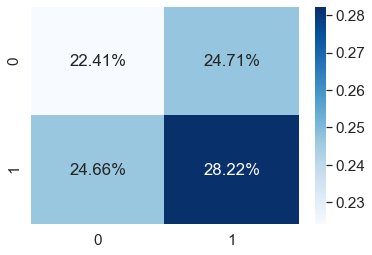

In [2710]:

sn.set(font_scale=1.4) # for label size
#sn.heatmap(confusion, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

The confusion matrix shows that the Random Forest classifier gives significantly better results than the neural network applied to the same task. There are more true negatives than false negatives and the false positives are only slightly more than the true positivs. Moreover, multiple runs of the Random Forest classifier do not give wildly diverging behaviour as in the case of the neural network classifier.

It would alsoe be interesting to see which time step is most useful in making the forecast:

In [2711]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feature_imp

29    0.044004
0     0.034394
27    0.033816
10    0.033757
18    0.033526
28    0.033471
17    0.033423
3     0.033310
6     0.033301
7     0.033258
19    0.033192
16    0.033172
2     0.033123
4     0.033083
5     0.032961
26    0.032890
8     0.032889
22    0.032832
11    0.032829
25    0.032813
12    0.032797
24    0.032718
9     0.032717
20    0.032611
1     0.032511
15    0.032509
14    0.032334
13    0.032105
21    0.032065
23    0.031590
dtype: float64

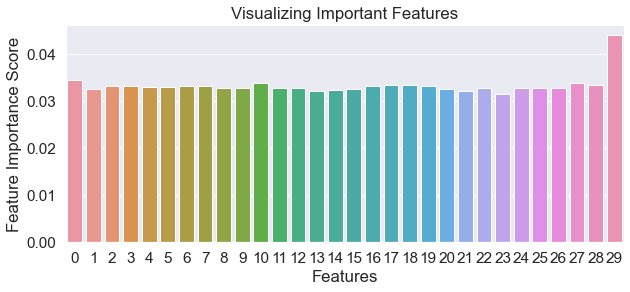

In [2712]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(y=feature_imp, x=feature_imp.index, ax = ax )
# Add labels to your graph
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

The feature importance graph shows that the step immmediatly preceding the forecast step is the most useful for making the forecast. This agrees with the baseline forecast where the best forecast was obtained by presisting the last data point in the training set. Surprisingly, the remaining 29 data points seem to be of similiar importance when we might have expected their important to decrease as we move further away from the forecasted point.

We now look at the ROC curve and other metrics.

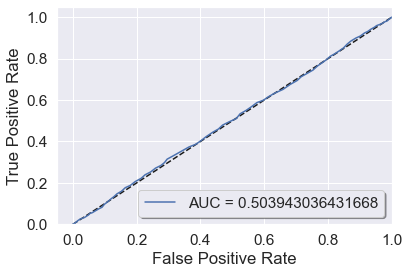

In [2713]:
# get roc/auc info
Y_score = clf.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(Y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [2714]:
print(classification_report(y_test, y_pred,
target_names=[" price increase", "price decrease"]))

                 precision    recall  f1-score   support

 price increase       0.48      0.48      0.48      2050
 price decrease       0.53      0.53      0.53      2301

       accuracy                           0.51      4351
      macro avg       0.50      0.50      0.50      4351
   weighted avg       0.51      0.51      0.51      4351



### Discussion

It seems the Random Forest classifier is performing significantly better than the neural network. Though the accuracy isn't much better the confusion matrix and other metrics are better behaved.

## Forecasting of the First Differenced  Bitcoin Time Series

I now apply the Random Forest Classifier to the time series of returns

### Data Preparation for Binary Classification - Returns Time Series

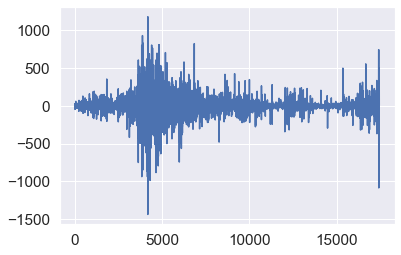

In [2715]:
data =diff.values.tolist()
plt.plot(data)

In [2716]:
# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data), STEP): 
    try:
        x_i = data[i:i+WINDOW]
        y_i = data[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if  next_close > 0:   # The condition corresponding to price increase in the next step for returns time series
            y_i = [1]
        else:
            y_i = [0] 

    except Exception as e:
        print ("e")
        break

    X.append(x_i)
    Y.append(y_i)

e


In [2717]:
X = np.where(np.isnan(X), ma.array(X, mask=np.isnan(X)).mean(axis=0), X)
print(X.shape)
X

(17407, 30)


array([[  -16.9 ,   -33.53,     4.55, ...,    26.74,    15.  ,    22.01],
       [  -33.53,     4.55,     8.85, ...,    15.  ,    22.01,     4.99],
       [    4.55,     8.85,    -1.39, ...,    22.01,     4.99,     7.94],
       ...,
       [  743.8 ,  -123.6 ,   343.6 , ...,  -164.5 ,  -152.1 ,    50.2 ],
       [ -123.6 ,   343.6 ,    39.  , ...,  -152.1 ,    50.2 ,   360.4 ],
       [  343.6 ,    39.  , -1087.7 , ...,    50.2 ,   360.4 ,    58.6 ]])

In [2718]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

C:\Users\jamil\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [2719]:
Y = np.where(np.isnan(Y), ma.array(Y, mask=np.isnan(Y)).mean(axis=0), Y)
print(Y.shape)
Y

(17407,)


array([1., 1., 1., ..., 1., 1., 1.])

In [2720]:
train_X = X[:int((len(X)+1)*.75)] 
test_X = X[int(len(X)*.75+1):] 

In [2721]:
train_Y = Y[:int((len(Y)+1)*.75)] 
test_Y = Y[int(len(Y)*.75+1):]

In [2722]:

X_train = (train_X)

# transform testing dataabs
X_test = (test_X)

In [2723]:
Y_train = train_Y
Y_test =  test_Y

In [2724]:
Y_test

array([1., 1., 0., ..., 1., 1., 1.])

In [2725]:
X_train.shape, X_test.shape
X_train

array([[-16.9 , -33.53,   4.55, ...,  26.74,  15.  ,  22.01],
       [-33.53,   4.55,   8.85, ...,  15.  ,  22.01,   4.99],
       [  4.55,   8.85,  -1.39, ...,  22.01,   4.99,   7.94],
       ...,
       [ 15.1 , -17.  ,  16.2 , ..., -20.8 ,  -3.7 ,   1.2 ],
       [-17.  ,  16.2 ,   3.1 , ...,  -3.7 ,   1.2 , 211.6 ],
       [ 16.2 ,   3.1 ,  12.3 , ...,   1.2 , 211.6 ,  29.9 ]])

In [2726]:
X_test

array([[    3.1,    12.3,   -10. , ...,   211.6,    29.9,    -2.1],
       [   12.3,   -10. ,    -9.2, ...,    29.9,    -2.1,    10.6],
       [  -10. ,    -9.2,     6.6, ...,    -2.1,    10.6,    20.8],
       ...,
       [  743.8,  -123.6,   343.6, ...,  -164.5,  -152.1,    50.2],
       [ -123.6,   343.6,    39. , ...,  -152.1,    50.2,   360.4],
       [  343.6,    39. , -1087.7, ...,    50.2,   360.4,    58.6]])

## Random Forest Classifier Forecasting of the Returns Time Series

### Results

In [2727]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
clf=RandomForestClassifier(n_estimators=150)

clf.fit(X_train,Y_train)

y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5343599172603999


This accuracy is the best attained so far, but again we must be cautious and examine the confusion matrix and other metrics before coming to a firm conclusion.

In [2728]:
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion))

Confusion matrix:
[[1128  922]
 [1104 1197]]


<AxesSubplot:>

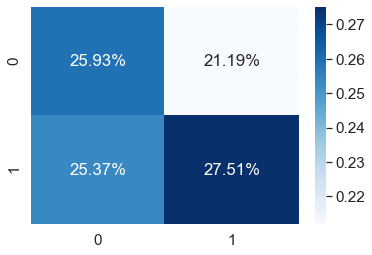

In [2729]:

sn.set(font_scale=1.4) # for label size
#sn.heatmap(confusion, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.2%', cmap='Blues')

This confusion matrix is the best obtained so far. 

In [2730]:
import pandas as pd

feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feature_imp

29    0.036760
17    0.034397
5     0.034220
7     0.034012
22    0.034011
15    0.033930
8     0.033863
14    0.033838
2     0.033704
19    0.033557
6     0.033499
25    0.033424
21    0.033403
1     0.033310
16    0.033297
26    0.033262
28    0.033248
27    0.032925
12    0.032866
18    0.032825
23    0.032772
10    0.032733
4     0.032713
20    0.032685
9     0.032652
0     0.032604
24    0.032515
3     0.032513
11    0.032422
13    0.032041
dtype: float64

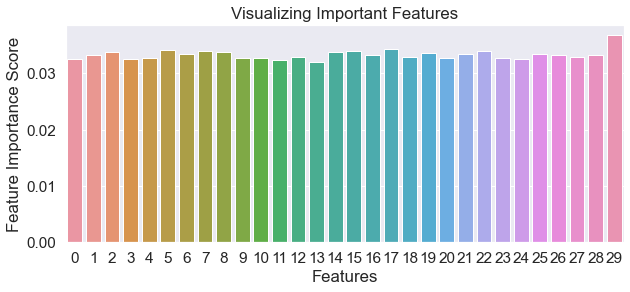

In [2731]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
fig_dims = (10, 4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.barplot(y=feature_imp, x=feature_imp.index, ax = ax )
# Add labels to your graph
plt.ylabel('Feature Importance Score')
plt.xlabel('Features')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()

The feature importance graph for the returns time series shows the last data point is only slightly more important than the rest. Though again, surpisingly, the importance of the features does not exhibit a decline with increasing time.

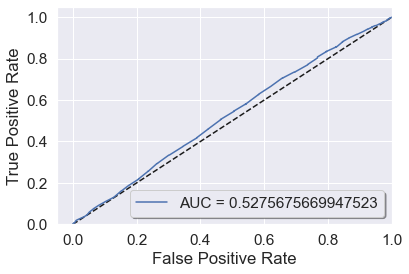

In [2732]:
# get roc/auc info
Y_score = clf.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(Y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
#plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [2733]:
print(classification_report(y_test, y_pred,
target_names=[" price increase", "price decrease"]))

                 precision    recall  f1-score   support

 price increase       0.51      0.55      0.53      2050
 price decrease       0.56      0.52      0.54      2301

       accuracy                           0.53      4351
      macro avg       0.54      0.54      0.53      4351
   weighted avg       0.54      0.53      0.53      4351



The ROC curve and other metrix clearly show that the Random Forest Classifier applied to the returns time series gives the best performance out of all classification frameworks so far studied.

# Conclusion

The Random Forest classifier applied to the time series of returns gave the best performance of all classification frameworks thus far considered. Not only the accuracy but all other metrics were clearly superior and better behaved. Random Forest classifiers perform quite well without too much tuning so default values of the hyperparameters were used. It may be possible to squeeze further improvements out of the classifier by carefully tuning the hyperparameters. This will be studied next. A further route to perfomaance improvement could be the use of the XGBoost algorithm in place of the Random Forest algorithm though this requires careful tuning of the hyperparameters to obtain optimal performance.